In [37]:
import sys
sys.path.append('../src')
from data import train_and_testloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes

In [2]:
phate_decay = 40
n_neighbors = 15
phate_gamma = 1
phate_knn = 15

In [3]:
X = np.load(f"../data/swiss_roll.npy")

Computing PHATE with phate_decay=40 and n_neighbors=15
Calculating PHATE...
  Running PHATE on 900 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.


  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.59 seconds.
Calculated PHATE in 1.34 seconds.


/tmp/ipykernel_2306464/3525774703.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(phate_coords)


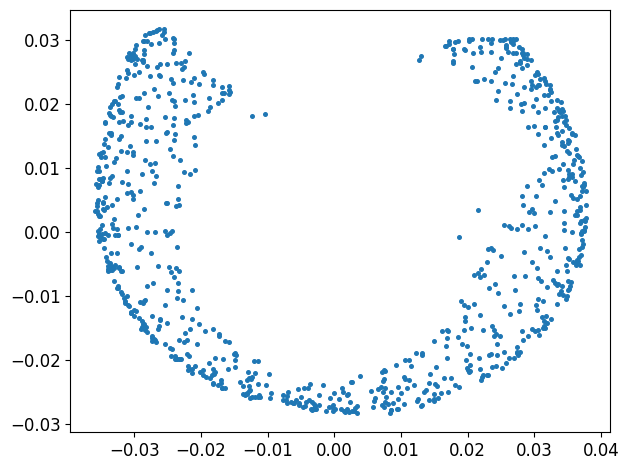

In [4]:
print(f"Computing PHATE with {phate_decay=} and {n_neighbors=}")
phate_op = phate.PHATE(gamma=phate_gamma, knn=phate_knn, random_state=42) #n_components = 2, decay=phate_decay, knn=self.n_neighbors
phate_coords = phate_op.fit_transform(X)
phate.plot.scatter2d(phate_coords)
phate_coordst = torch.tensor(phate_coords)
phate_D = torch.cdist(phate_coordst, phate_coordst).cpu().detach().numpy()
np.save(f"../data/phate_swiss_roll_coords.npy", phate_coords)
np.save(f"../data/phate_swiss_roll_D.npy", phate_D)

In [5]:
op = HeatGeo(
    knn=5,
    tau=0.5,
    harnack_regul=0.5,
    denoising=False,
    denoise_regul=0.,
)
X_heatgeo = op.fit_transform(X)
op.metric_computation(X)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Using s_gd2 for MDS. None


/tmp/ipykernel_2306464/4082592275.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(X_heatgeo)


<Axes: >

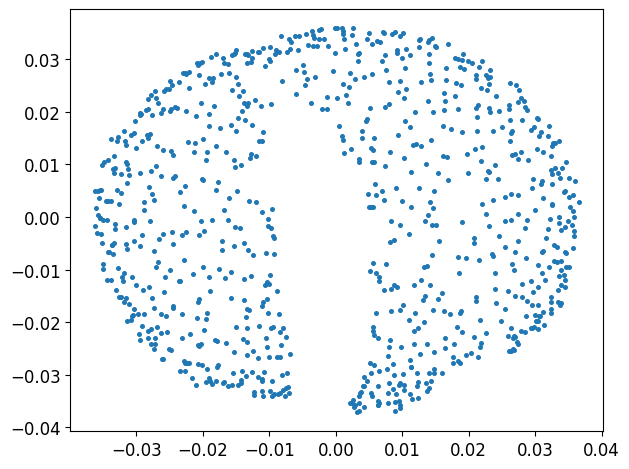

In [6]:
phate.plot.scatter2d(X_heatgeo)

In [7]:
op.dist.shape

(900, 900)

In [8]:
# def dist_fn(x, knn, tau, harnack_regul, denoising, denoise_regul):
#     op = HeatGeo(
#         knn=knn,
#         tau=tau,
#         harnack_regul=harnack_regul,
#         denoising=denoising,
#         denoise_regul=denoise_regul,
#     )
#     op.fit(x)
#     op.metric_computation(x)
#     return op.dist

In [9]:
dist_t = phate_D[np.triu_indices(phate_D.shape[0], k=1)]

In [10]:
# dist_t2 = phate_D[torch.triu_indices(phate_D.shape[0], phate_D.shape[1], 1)]

In [11]:
trainloader, testloader = train_and_testloader_from_pc(
    X, # <---- Pointcloud
    phate_D, # <---- Distance matrix to match
    batch_size=64)

In [12]:
train_sample = next(iter(trainloader))

In [13]:
max_epochs = 50
model = AEDist(
    dim=train_sample['x'].shape[1],
    emb_dim=2,
    log_dist=False,
)
early_stopping = EarlyStopping('val_loss', patience=500)
trainer = Trainer(
    max_epochs=max_epochs, 
    accelerator='cuda',
    callbacks=[early_stopping],
    log_every_n_steps=50,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    model=model,
    train_dataloaders=trainloader,
    val_dataloaders=testloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | encoder | MLP  | 8.7 K 
1 | decoder | MLP  | 8.7 K 
---------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we f

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [16]:
X_tensor = torch.from_numpy(X).float()

In [23]:
model_z = model(X_tensor)[1].cpu().detach().numpy()

/tmp/ipykernel_2306464/678367026.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(model_z)


<Axes: >

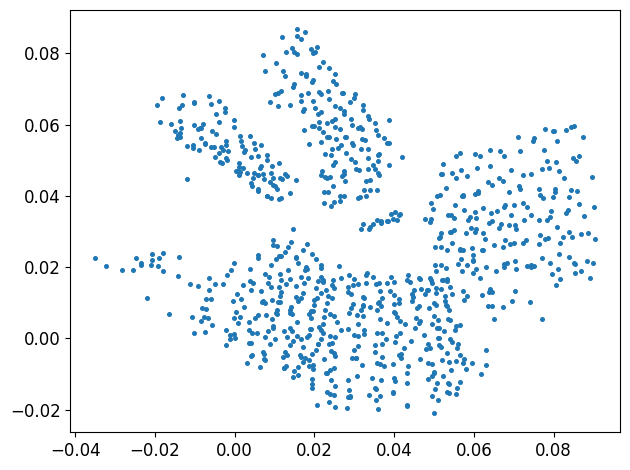

In [25]:
phate.plot.scatter2d(model_z)

In [26]:
max_epochs = 50
model = AEDist(
    dim=train_sample['x'].shape[1],
    emb_dim=2,
    log_dist=True,
)
early_stopping = EarlyStopping('val_loss', patience=500)
trainer = Trainer(
    max_epochs=max_epochs, 
    accelerator='cuda',
    callbacks=[early_stopping],
    log_every_n_steps=50,
)

trainer.fit(
    model=model,
    train_dataloaders=trainloader,
    val_dataloaders=testloader,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/lightning_logs/version_16249683/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Na

Sanity Checking: 0it [00:00, ?it/s]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many w

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


/tmp/ipykernel_2306464/2083934709.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(model_z2)


<Axes: >

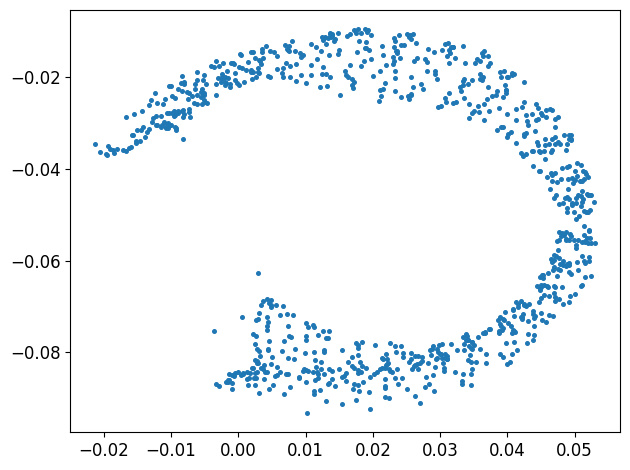

In [27]:
X_tensor = torch.from_numpy(X).float()
model_z2 = model(X_tensor)[1].cpu().detach().numpy()
phate.plot.scatter2d(model_z2)

In [28]:
phate_coords

array([[-0.01035642,  0.01837105],
       [-0.01574893,  0.02156426],
       [-0.01743365,  0.02011879],
       ...,
       [ 0.02138933,  0.02359628],
       [ 0.01776433,  0.02634358],
       [ 0.01271268,  0.02679486]])

In [29]:
model_z2

array([[ 0.00293057, -0.06270296],
       [ 0.00487966, -0.06847958],
       [ 0.00663126, -0.0698439 ],
       ...,
       [-0.01672779, -0.0286263 ],
       [-0.02122746, -0.03465127],
       [-0.02053951, -0.03635069]], dtype=float32)

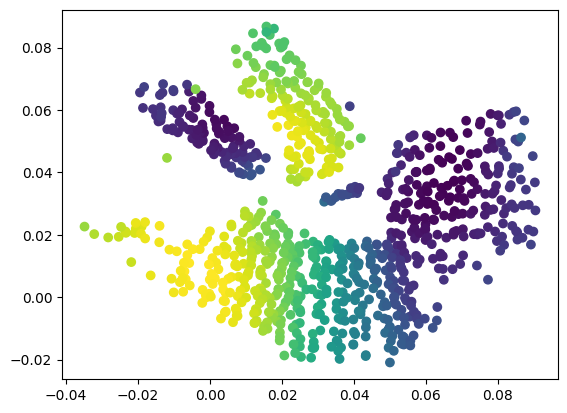

In [31]:
import matplotlib.pyplot as plt
plt.scatter(model_z[:,0], model_z[:,1], c=phate_coords[:,0], cmap='viridis')

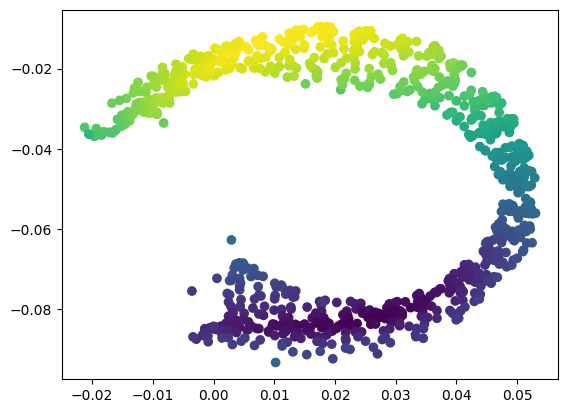

In [32]:
import matplotlib.pyplot as plt
plt.scatter(model_z2[:,0], model_z2[:,1], c=phate_coords[:,0], cmap='viridis')

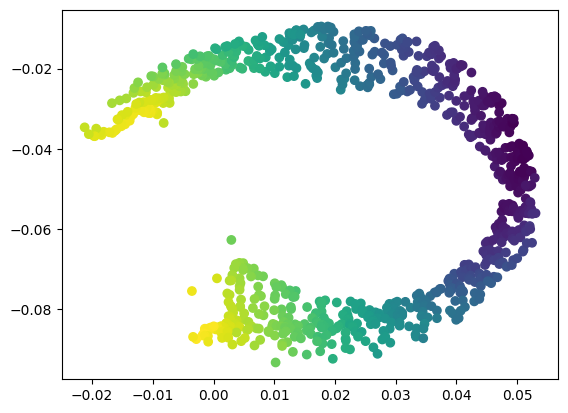

In [33]:
import matplotlib.pyplot as plt
plt.scatter(model_z2[:,0], model_z2[:,1], c=phate_coords[:,1], cmap='viridis')

In [38]:
pc_s, z2, disparity = procrustes(phate_coords, model_z2)

In [39]:
disparity

0.015772040309718176

In [40]:
pc_s1, z, disparity1 = procrustes(phate_coords, model_z)

In [41]:
disparity1

0.4850024714828389

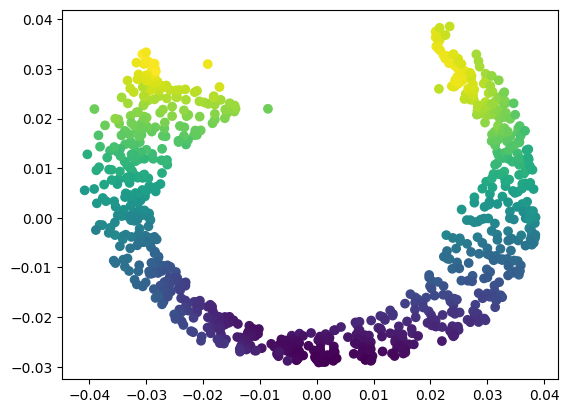

In [42]:
import matplotlib.pyplot as plt
plt.scatter(z2[:,0], z2[:,1], c=phate_coords[:,1], cmap='viridis')